#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

#### Load Results

In [3]:
outputs_path = Path("../outputs")
with open(outputs_path / "model_results.pkl", "rb") as f:
    results = pickle.load(f)

assets_path = Path("../data/assets")
factors_path = Path("../data/factors")

returns = pd.read_csv(assets_path / "asset_returns.csv", index_col=0, parse_dates=True)
factors = pd.read_csv(factors_path / "ff3_daily_clean.csv", index_col=0, parse_dates=True)

#### Align Data

In [4]:
returns = returns.loc[factors.index.intersection(returns.index)]
factors = factors.loc[returns.index]

excess_returns = returns.sub(factors["RF"], axis=0)

#### Prepare Portfolio

In [5]:
tickers = returns.columns
n_assets = len(tickers)
weights = np.ones(n_assets) / n_assets

#### Build Beta Matrix

In [19]:
beta_capm = pd.DataFrame(index=tickers, columns=["Mkt-RF"])

for ticker in tickers:
    model = results[ticker]["CAPM"]
    beta_capm.loc[ticker, ["Mkt-RF"]] = model.params[["Mkt-RF"]]

beta_capm = beta_capm.astype(float)

In [6]:
beta_ff3 = pd.DataFrame(index=tickers, columns=["Mkt-RF", "SMB", "HML"])

for ticker in tickers:
    model = results[ticker]["FF3"]
    beta_ff3.loc[ticker, ["Mkt-RF", "SMB", "HML"]] = model.params[["Mkt-RF", "SMB", "HML"]]

beta_ff3 = beta_ff3.astype(float)

#### Factor Covariance and Residual Variance

In [7]:
factor_cov = factors[["Mkt-RF", "SMB", "HML"]].cov()
residual_var = pd.Series({ticker: results[ticker]["FF3"].mse_resid for ticker in tickers})

In [21]:
factor_cov_capm = factors[["Mkt-RF"]].cov()

In [15]:
d = pd.DataFrame(residual_var)
d.columns = ['Residual Variance']
d.T

,AAPL,AMZN,JNJ,JPM,KO,META,MSFT,PFE,TSLA,XOM
Residual Variance,0.00013,0.000202,0.000106,0.00009,0.000089,0.000389,0.000077,0.000203,0.001131,0.000183


In [16]:
residual_var_capm = pd.Series({ticker: results[ticker]["CAPM"].mse_resid for ticker in tickers})
d = pd.DataFrame(residual_var_capm)
d.columns = ['Residual Variance']
d.T

,AAPL,AMZN,JNJ,JPM,KO,META,MSFT,PFE,TSLA,XOM
Residual Variance,0.00015,0.000259,0.000116,0.000174,0.000103,0.000433,0.00011,0.00021,0.001203,0.000274


#### Risk Decomposition

In [31]:
portfolio_var_factor

0.0001542451355195876

In [32]:
beta_ff3

,Mkt-RF,SMB,HML
AAPL,1.179768,-0.305689,-0.380873
AMZN,1.114778,-0.148886,-0.731681
JNJ,0.531383,-0.407725,0.130028
JPM,1.112056,-0.169943,0.899367
KO,0.609986,-0.386084,0.265866
META,1.256849,-0.164144,-0.641504
MSFT,1.192741,-0.444452,-0.465945
PFE,0.587875,-0.350803,0.125330
TSLA,1.460075,0.670193,-0.721295
XOM,0.874829,-0.016910,0.940476


In [8]:
portfolio_beta = np.dot(weights, beta_ff3)
portfolio_var_factor = np.dot(portfolio_beta, np.dot(factor_cov, portfolio_beta.T))
portfolio_var_idiosyncratic = np.dot(weights**2, residual_var)
portfolio_var_total = portfolio_var_factor + portfolio_var_idiosyncratic

#### Plot Decomposition

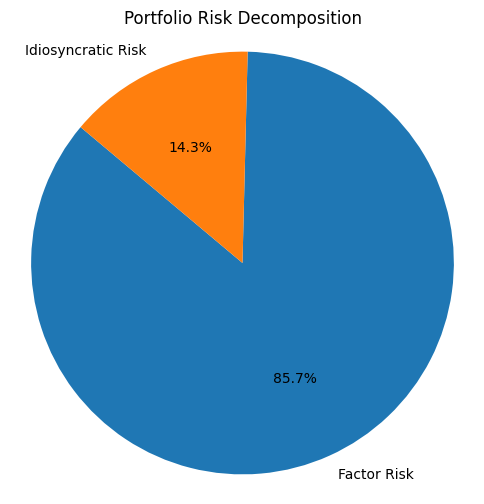

In [9]:
labels = ['Factor Risk', 'Idiosyncratic Risk']
sizes = [portfolio_var_factor, portfolio_var_idiosyncratic]

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=["#1f77b4", "#ff7f0e"])
ax.axis('equal')
plt.title('Portfolio Risk Decomposition')
plt.show()

In [10]:
print("🔵 Portfolio Total Volatility (daily std dev): {:.5f}".format(np.sqrt(portfolio_var_total)))
print("🔵 Portion of total variance explained by factors: {:.2%}".format(portfolio_var_factor/portfolio_var_total))
print("🔵 Portion of total variance due to idiosyncratic risk: {:.2%}".format(portfolio_var_idiosyncratic/portfolio_var_total))

🔵 Portfolio Total Volatility (daily std dev): 0.01349
🔵 Portion of total variance explained by factors: 85.72%
🔵 Portion of total variance due to idiosyncratic risk: 14.28%


In [26]:
0.01349 * np.sqrt(252)

0.21414711111756798

In [22]:
portfolio_beta = np.dot(weights, beta_capm)
portfolio_var_factor = np.dot(portfolio_beta, np.dot(factor_cov_capm, portfolio_beta.T))
portfolio_var_idiosyncratic = np.dot(weights**2, residual_var_capm)
portfolio_var_total = portfolio_var_factor + portfolio_var_idiosyncratic

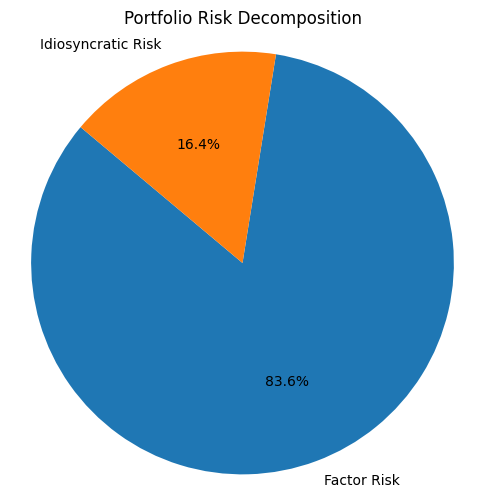

In [23]:
labels = ['Factor Risk', 'Idiosyncratic Risk']
sizes = [portfolio_var_factor, portfolio_var_idiosyncratic]

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=["#1f77b4", "#ff7f0e"])
ax.axis('equal')
plt.title('Portfolio Risk Decomposition')
plt.show()

In [24]:
print("🔵 Portfolio Total Volatility (daily std dev): {:.5f}".format(np.sqrt(portfolio_var_total)))
print("🔵 Portion of total variance explained by factors: {:.2%}".format(portfolio_var_factor/portfolio_var_total))
print("🔵 Portion of total variance due to idiosyncratic risk: {:.2%}".format(portfolio_var_idiosyncratic/portfolio_var_total))

🔵 Portfolio Total Volatility (daily std dev): 0.01358
🔵 Portion of total variance explained by factors: 83.58%
🔵 Portion of total variance due to idiosyncratic risk: 16.42%


In [ ]:
0.01349 * np.sqrt(252), 0.01358 * np.sqrt(252)

(0.21414711111756798, 0.21557581682554286)